In [ ]:
## https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

## https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
currency = pd.ExcelFile('currency_data_time_series.xlsx', index_col=['Time'], parse_dates=['Time'])
df_currency = currency.parse(0)
df_currency.head()

,Time,GEMS_GEMS_SPENT
1,5/1/17,1199436
2,5/2/17,1045515
3,5/3/17,586111
4,5/4/17,856601
5,5/5/17,793775


In [3]:
ads = pd.ExcelFile('data_ad_time_series.xlsx', index_col=['Time'], parse_dates=['Time'] )
df_ads = ads.parse(0)
df_ads.head()

,Time,Ads
1,2017-09-13T00:00:00,80115
2,2017-09-13T01:00:00,79885
3,2017-09-13T02:00:00,89325
4,2017-09-13T03:00:00,101930
5,2017-09-13T04:00:00,121630


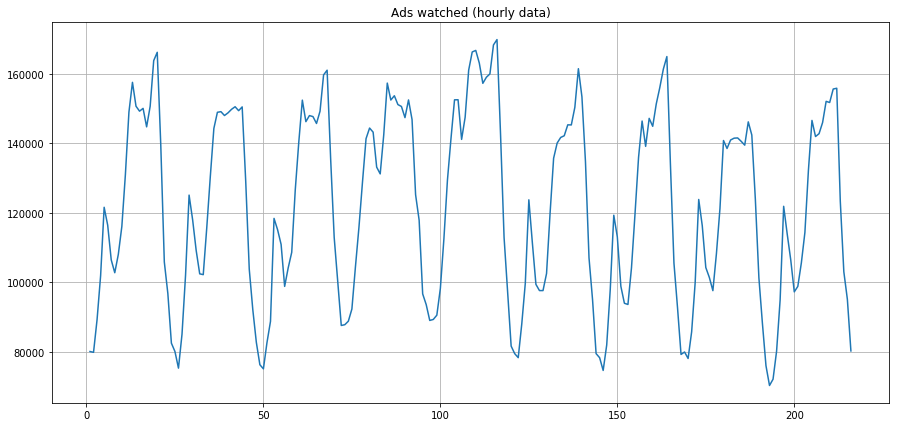

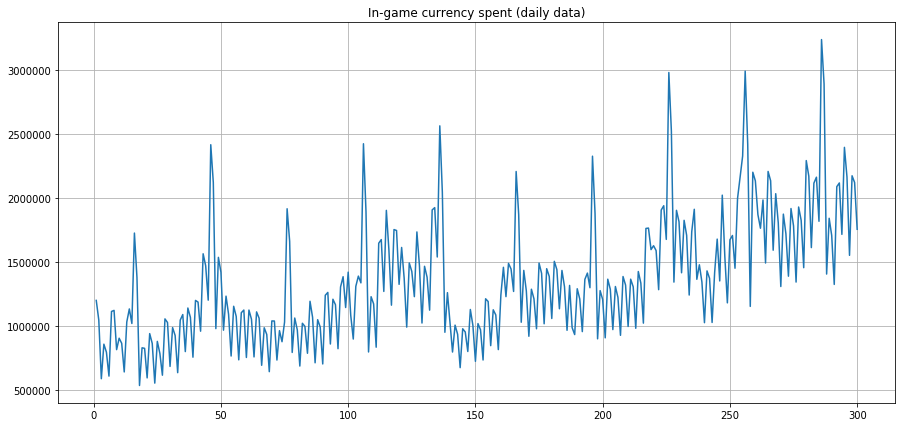

In [4]:

plt.figure(figsize=(15, 7))
plt.plot(df_ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(df_currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()


In [5]:
# Importing everything for Forcast Quality Metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
## Move, smoothe, evaluate :
## Let’s start with a naive hypothesis — “tomorrow will be the same as today”, but instead of a model
## like ŷ(t)=y(t−1) (which is actually a great baseline for any time series prediction problems and 
## sometimes it’s impossible to beat it with any model) we’ll assume that the future value of the variable
## depends on the average n of its previous values and therefore we’ll use moving average.

## y_hat_(t) = (1/k)* (Sum (y_(t-n)) over n = 0 to (n-1))


In [6]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_ads.Ads, 24) # prediction of the last observed day (past 24 hour)
##                               i.e. here, average of 24 hrs.data of 21/9/2017 : Check the excel file

116805.0

In [5]:
## Unfortunately we can’t make this prediction long-term — to get one for the next step we need 
## the previous value to be actually observed. But moving average has another use case — smoothing
## of the original time series to indicate trends. Pandas has an implementation available
## DataFrame.rolling(window).mean(). The wider the window - the smoother will be the trend. In the 
## case of the very noisy data, which can be very often encountered in finance, this procedure can
## help to detect common patterns.

In [7]:
series_ad = df_ads.Ads
series_ad

1       80115
2       79885
3       89325
4      101930
5      121630
6      116475
7      106495
8      102795
9      108055
10     116125
11     131030
12     149020
13     157590
14     150715
15     149295
16     150100
17     144780
18     150690
19     163840
20     166235
21     139520
22     105895
23      96780
24      82520
25      80125
26      75335
27      85105
28     102080
29     125135
30     118030
        ...  
187    146215
188    142425
189    123945
190    101360
191     88170
192     76050
193     70335
194     72150
195     80195
196     94945
197    121910
198    113950
199    106495
200     97290
201     98860
202    105635
203    114380
204    132335
205    146630
206    141995
207    142815
208    146020
209    152120
210    151790
211    155665
212    155890
213    123395
214    103080
215     95155
216     80285
Name: Ads, Length: 216, dtype: int64

In [8]:
window=3
scale = 1.96
rol_mean_4 = series_ad.rolling(window=window).mean()
mae_4 = mean_absolute_error(series_ad[window:], rol_mean_4[window:])
deviation_4 = np.std(series_ad[window:] - rol_mean_4[window:])
lower_bond_4 = rol_mean_4 - (mae_4 + scale * deviation_4)
upper_bond_4 = rol_mean_4 + (mae_4 + scale * deviation_4)


In [9]:
series_ad<lower_bond_4

1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22      True
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
       ...  
187    False
188    False
189    False
190    False
191    False
192    False
193    False
194    False
195    False
196    False
197    False
198    False
199    False
200    False
201    False
202    False
203    False
204    False
205    False
206    False
207    False
208    False
209    False
210    False
211    False
212    False
213    False
214    False
215    False
216    False
Name: Ads, Length: 216, dtype: bool

In [10]:
anomalies_4 = pd.DataFrame(index=series_ad.index, columns = series_ad)
#anomalies_4[series_ad<lower_bond_4] = series_ad[series_ad<lower_bond_4]
aa = anomalies_4[series_ad<lower_bond_4]

#anomalies_4[series_ad>upper_bond_4] = series_ad[series_ad>upper_bond_4]
print(type(aa))
print(type(df_ads))
aa

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Ads,80115,79885,89325,101930,121630,116475,106495,102795,108055,116125,...,142815,146020,152120,151790,155665,155890,123395,103080,95155,80285
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
bb = aa.T
print(min(bb[1:]))


22


In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "m", label="Rolling mean trend")  ## "m" for magenta color

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
#            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies = pd.DataFrame(index=series.index, columns = series)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


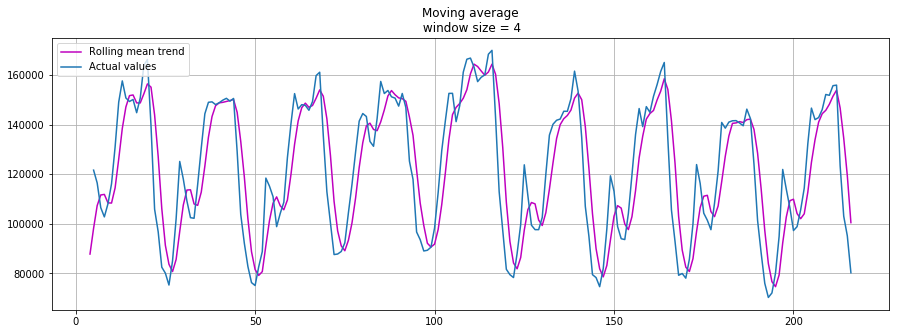

In [9]:
## Smoothing by last 4 hours

plotMovingAverage(df_ads.Ads,4)


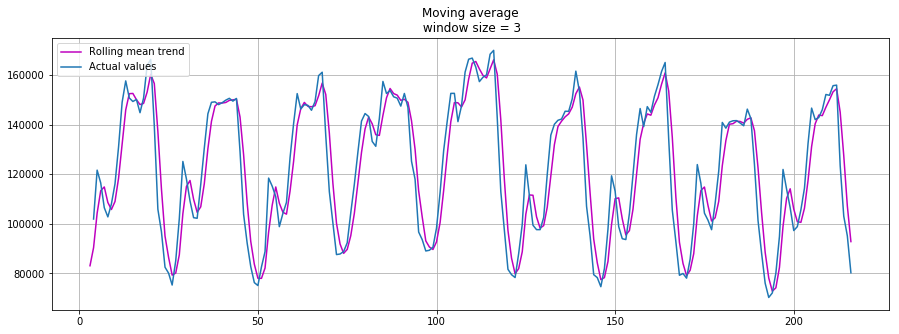

In [10]:
## Smoothing by last 12 hours

plotMovingAverage(df_ads.Ads, 3)


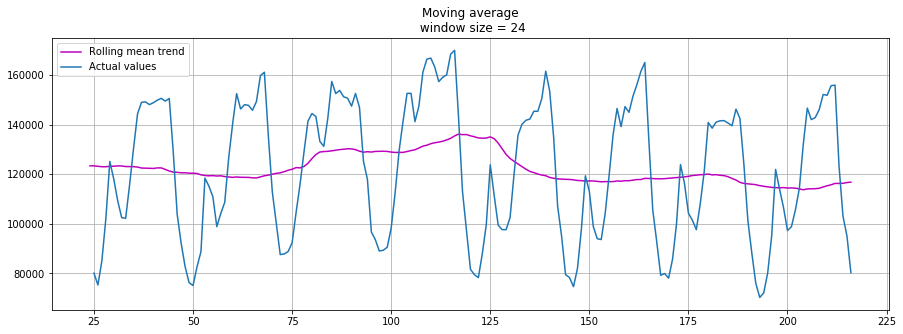

In [11]:
## Smoothing by 24 hours — we get daily trend

plotMovingAverage(df_ads.Ads, 24)


In [ ]:
## As you can see, applying daily(window=24) smoothing on hour data allowed us to clearly see the dynamics of ads 
## watched. During the weekends the values are higher (weekends — time to play) and weekdays are generally lower.


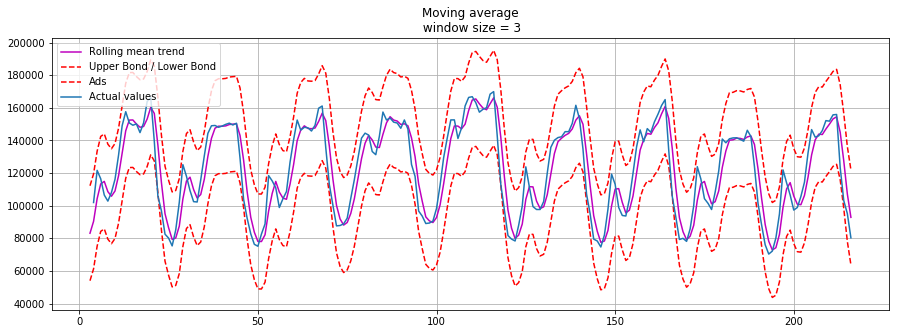

In [12]:
## We can also plot confidence intervals for our smoothed values

plotMovingAverage(df_ads.Ads, 3, plot_intervals=True)


In [ ]:
## And now let’s create a simple anomaly detection system with the help of the moving average. Unfortunately, 
## in this particular series everything is more or less normal, so we’ll intentionally make one of the values 
## abnormal in the dataframe ad_anomaly


In [13]:
ad_anomaly = df_ads.Ads.copy()
print(ad_anomaly[197])
print(ad_anomaly.iloc[-20])
print('=======================')

ad_anomaly.iloc[-20] = ad_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 
print(ad_anomaly[197])
print(ad_anomaly.iloc[-20])


121910
121910
24382.0
24382.0


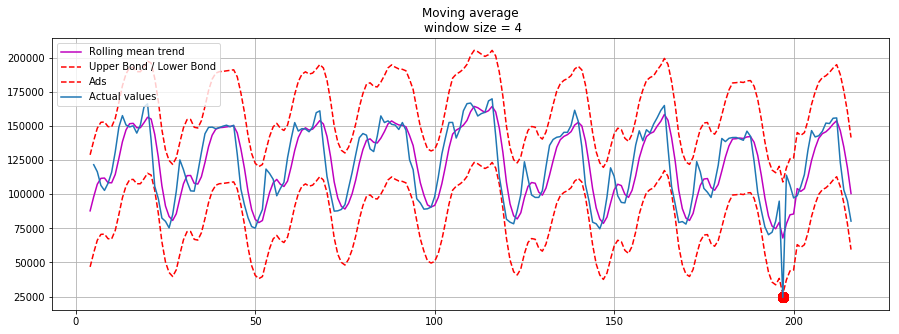

In [14]:
## Let’s see, if this simple method can catch the anomaly

plotMovingAverage(ad_anomaly, 4, plot_intervals=True, plot_anomalies=True)

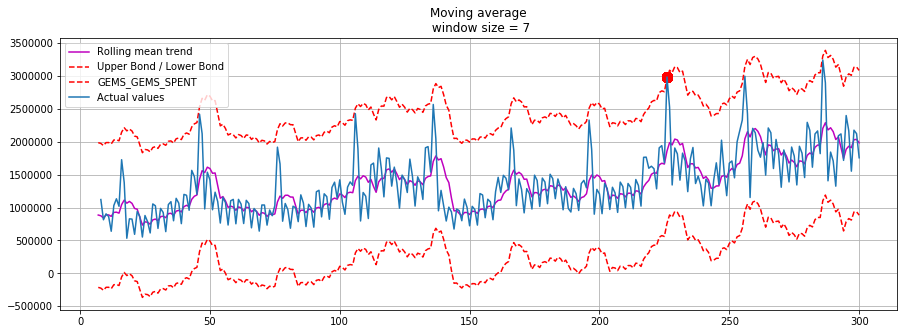

In [15]:
# Neat! What about the second series i.e. currency (with weekly smoothing i.e window = 7):

# plotMovingAverage(df_currency.GEMS_GEMS_SPENT, 7, plot_intervals=True, plot_anomalies=True)

currency_series = df_currency.GEMS_GEMS_SPENT.copy()

plotMovingAverage(currency_series, 7, plot_intervals=True, scale = 2.75, plot_anomalies=True)

## Pl. note the 'scale' (=1.96, here) together with 'window' plays a very important role in anomaly plotting.
## for 'currency_series', when scale = 1.96, w>1 gives error
## for 'ads series', when scale = 1.96, w=3 gives error
## lower bound and upper bound changes with scale hence this problem

In [ ]:
## Oh no! Here is the downside of our simple approach — it did not catch monthly seasonality in our data and 
## marked almost all 30-day peaks as an anomaly. If you don’t want to have that many false alarms — it’s best
## to consider more complex models.

## Weighted average is a simple modification of the moving average, inside of which observations have different
## weights summing up to one, usually more recent observations have greater weight.

## y_hat_(t) = (1/k)* (Sum (y_(t-n)) over n = 0 to (n-1)) - earlier expression
## Now, y_hat_(t) = (Sum (w_n * y_(t+1-n)) 

In [16]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(series_ad, [0.6, 0.3, 0.1])


98423.0

In [21]:
weights = [0.7, 0.3, 0.1]
weights.reverse()
weights

[0.1, 0.3, 0.7]

In [17]:
series_ad.iloc[-2]

95155

In [ ]:
## Exponential smoothing:
## And now let’s take a look at what happens if instead of weighting the last nn values of the time series we 
## start weighting all available observations while exponentially decreasing weights as we move further back in
## historical data. There’s a formula of the simple exponential smoothing that will help us in that:

## y_hat_(t) = alpha * y_(t) + (1 - alpha) * y_(t-1)

## Here the model value is a weighted average between the current true value and the previous model values. The 
## α weight is called a smoothing factor. It defines how quickly we will “forget” the last available true 
## observation. The less α is the more influence previous model values have, and the smoother the series is.

## Exponentiality is hiding in the recursivity of the function — we multiply each time (1−α) by the previous model 
## value which, in its turn, also containes (1−α) and so forth until the very beginning.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])


In [18]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


In [19]:
series_ad = series_ad.reset_index(drop=True) ## this is required to reset the index starting from '0'

In [20]:
result_1 = exponential_smoothing(series_ad, .3)
print(len(result_1))
print('+++++++++++++++')
print(result_1)

216
+++++++++++++++
[80115, 80046.0, 82829.7, 88559.79, 98480.85299999999, 103879.09709999998, 104663.86796999998, 104103.20757899998, 105288.74530529998, 108539.62171370997, 115286.73519959698, 125406.71463971789, 135061.7002478025, 139757.69017346174, 142618.88312142322, 144863.21818499625, 144838.25272949738, 146593.77691064816, 151767.6438374537, 156107.8506862176, 151131.4954803523, 137560.54683624662, 125326.38278537263, 112484.46794976083, 102776.62756483258, 94544.1392953828, 91712.39750676796, 94822.67825473756, 103916.37477831628, 108150.4623448214, 108472.82364137497, 106673.47654896247, 105343.43358427372, 108492.4035089916, 115106.68245629412, 123872.17771940588, 131401.52440358413, 136726.06708250887, 140120.2469577562, 142727.17287042935, 144858.02100930054, 146571.6147065104, 147432.13029455725, 148358.49120619008, 142589.94384433306, 130957.46069103313, 119322.72248372319, 108355.40573860623, 98743.28401702436, 91659.29881191705, 88953.50916834193, 88905.95641783935, 9

In [21]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "m", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

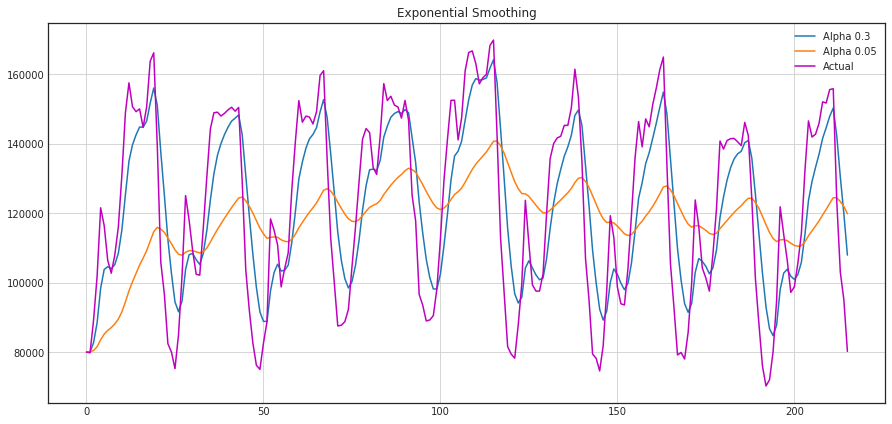

In [22]:
plotExponentialSmoothing(series_ad, [0.3, 0.05])

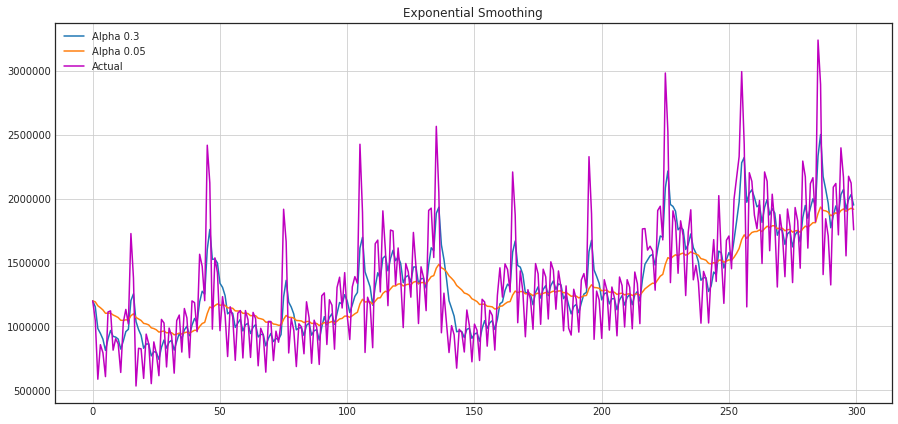

In [23]:
currency_series = currency_series.reset_index(drop=True)
plotExponentialSmoothing(currency_series, [0.3, 0.05])

In [ ]:
## Double exponential smoothing :
## Until now all we could get from our methods in the best case was just a single future point prediction (and
## also some nice smoothing), that’s cool but not enough, so let’s extend exponential smoothing so that we can
## predict two future points (of course, we also get some smoothing).

## Series decomposition should help us — we obtain two components: intercept (also, level) ℓ and trend (also, slope)
## b. We’ve learnt to predict intercept (or expected series value) using previous methods, and now we will apply the
## same exponential smoothing to the trend, believing naively or perhaps not that the future direction of the time
## series changes depends on the previous weighted changes.

## l_x = alpha * y_x + (1 - alpha) * (l_(x-1) + b_(x-1))
## b_x = beta * (l_x - l_(x-1)) + (1 - beta) * b_(x-1)
## y_hat_(x+1) = l_x + b_x

In [ ]:
## As a result we get a set of functions. The first one describes intercepts, as before it depends on the current
## value of the series,and the second term is now split into previous value of the level and of the trend. The 
## second function describes trend - it depends on the level changes at the current step and on the previous 
## value of the trend. In this case 'beta' coefficient is a weight in the exponential smoothing. The final 
## prediction is the sum of the model values of the intercept and trend.

In [24]:
def double_exponential_smoothing(series, alpha, beta):
    
    """
        series - dataset with time series
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    
    # first value is same as the series 
    
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level + trend)
        trend = beta*(level - last_level) + (1-beta)*trend
        result.append(level + trend)
    return result
    

In [25]:
result_2 = double_exponential_smoothing(series_ad, alpha=0.9, beta=0.9)
# double_exponential_smoothing(series_ad, alpha=[0.9, 0.02], beta=[0.9, 0.02])
print(len(result_2))

217


In [26]:
result_2

[80115,
 79655.0,
 95960.7,
 113770.90299999999,
 139647.79187000002,
 118826.01934229999,
 97773.716422267,
 96405.72582822744,
 110438.83884795925,
 123710.94068308544,
 144381.08891329882,
 166396.6217165481,
 169177.8114064691,
 148313.5531362212,
 145744.09926885722,
 149739.93347434647,
 141333.97078067478,
 153390.75817896103,
 174895.32279383123,
 172186.41779231495,
 121412.2288803882,
 73503.35459608107,
 79363.0499448247,
 69672.14902439107,
 75014.36822259094,
 71497.30188211227,
 90960.83072355344,
 117191.21072161927,
 146998.21803691424,
 120120.16215854319,
 100682.77522228609,
 94115.73859860864,
 99828.18667136789,
 125609.00027483582,
 145411.19141256562,
 158918.09548216042,
 156391.32854856993,
 150435.17573086923,
 146900.4681070951,
 148786.71817797067,
 150738.40146090195,
 151463.1646058645,
 148879.8775896105,
 150922.04804040058,
 114223.70617275512,
 79339.31998605892,
 75771.78217868159,
 72610.53483321177,
 69490.02688376325,
 72679.85431297016,
 87825.555

In [27]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with time series
        alphas - list of floats, smoothing parameter for level
        betas - list of floats, smoothing parameter for trend
 
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, "m", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True);

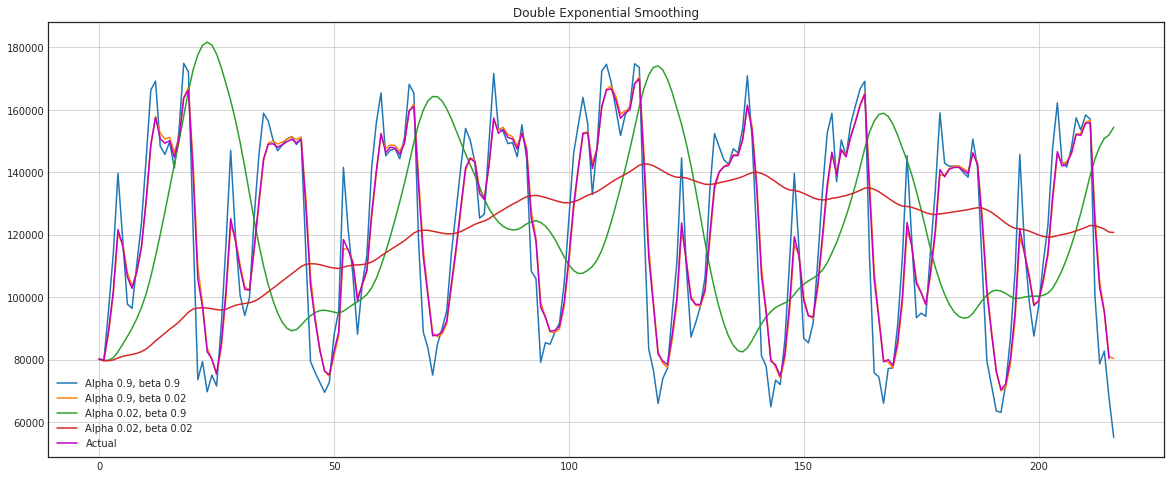

In [28]:
plotDoubleExponentialSmoothing(series_ad, alphas=[0.9, 0.02], betas=[0.9, 0.02])

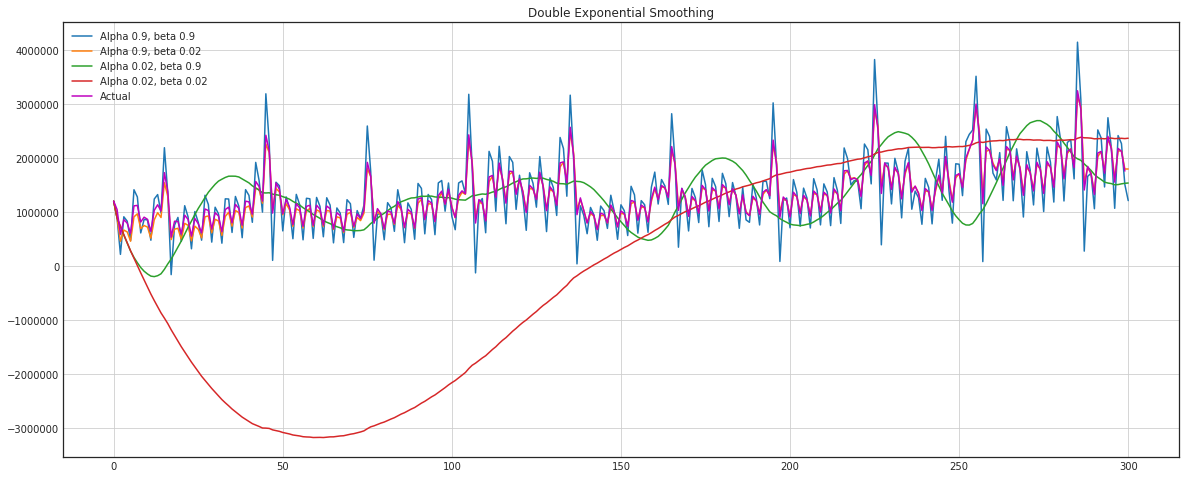

In [29]:
plotDoubleExponentialSmoothing(currency_series, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
## Now we have to tune two parameters - alpha and beta. The former is responsible for the series smoothing
## around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight
## the latest observations will have and the less smoothed the model series will be. Combinations of the 
## parameters may produce really weired results, especially if set manually. We will look into choosing parameters
## automatically in a bit, immediately after triple exponential smoothing.

In [ ]:
## Triple exponential smoothing a.k.a. Holt-Winters :

## Hooray! We’ve successfully reached our next variant of exponential smoothing, this time triple.

## The idea of this method is that we add another, third component — seasonality. This means we should’t use 
## the method if our time series do not have seasonality, which is not the case in our example. Seasonal component
## in the model will explain repeated variations around intercept and trend, and it will be described by the length
## of the season, in other words by the period after which variations repeat. For each observation in the season
## there’s a separate component, for example, if the length of the season is 7 (weekly seasonality), we will have 
## 7 seasonal components, one for each day of the week.

## Now we get a new system:

## l_x = alpha * (y_x - s_(x-L) + (1 - alpha) * (l_(x-1) + b_(x-1))
## b_x = beta * (l_x - l_(x-1)) + (1 - beta) * b_(x-1)
## s_x = gama * (y_x - l_x) + (1 - gama) * s_(x_L)
## y_hat_(x+m) = l_x + m * b_x + s_(x-L+1+(m-1)m0dL)

In [ ]:
## Additionally, to build confidence intervals, we need to include Brutlag method into the model :

## y_hat_max = l_(x-1) + b_(x-1) + s_(x-T) + m * d_(t-T)
## y_hat_min = l_(x-1) + b_(x-1) + s_(x-T) - m * d_(t-T)
##  d_t = gama * |y_t - y_hat_t| + (1-gama) * d_(t-T)

## where T is the length of the season, d is the predicted deviation, and the other parameters were taken from
## the triple exponential smoothing. You can read more about the method and its applicability to anomalies detection
## in time series *here.

## Below is the code for a triple exponential smoothing model, also known by the last names of its creators — 
## Charles Holt and his student Peter Winters along with confidence intervals :

In [30]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])


In [ ]:
## Time series cross validation

## Before we start building model let’s talk first about how to estimate model parameters automatically.

## There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell
## us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function
## for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the 
## global minimum of error.

## The question is how to do cross-validation on time series, because, you know, time series do have time structure
## and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time 
## dependencies between observations will be lost. That’s why we will have to use a bit more tricky approach to 
## optimization of the model parameters, I don’t know if there’s an official name to it but on *CrossValidated,
## where one can find all the answers but the Answer to the Ultimate Question of Life, the Universe, and Everything,
## “cross-validation on a rolling basis” was proposed as a name.

## The idea is rather simple — we train our model on a small segment of the time series, from the beginning until 
## some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until
## t+n value and make predictions from t+n until t+2∗n, and we continue moving our test segment of the time series
## until we hit the last available observation. As a result we have as many folds as many n will fit between the 
## initial training sample and the last observation.


## Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model, recall 
## that we have daily seasonality in ads, hence the slen=24 parameter

In [31]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


In [ ]:
## In the Holt-Winters model, as well as in the other models of exponential smoothing, there’s a constraint on how
## big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function
## we have to choose an algorithm that supports constraints on model parameters, in our case — Truncated Newton
## conjugate gradient.

In [34]:
%%time
data = series_ad[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()


0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.83 s


In [ ]:
## Chart rendering code :

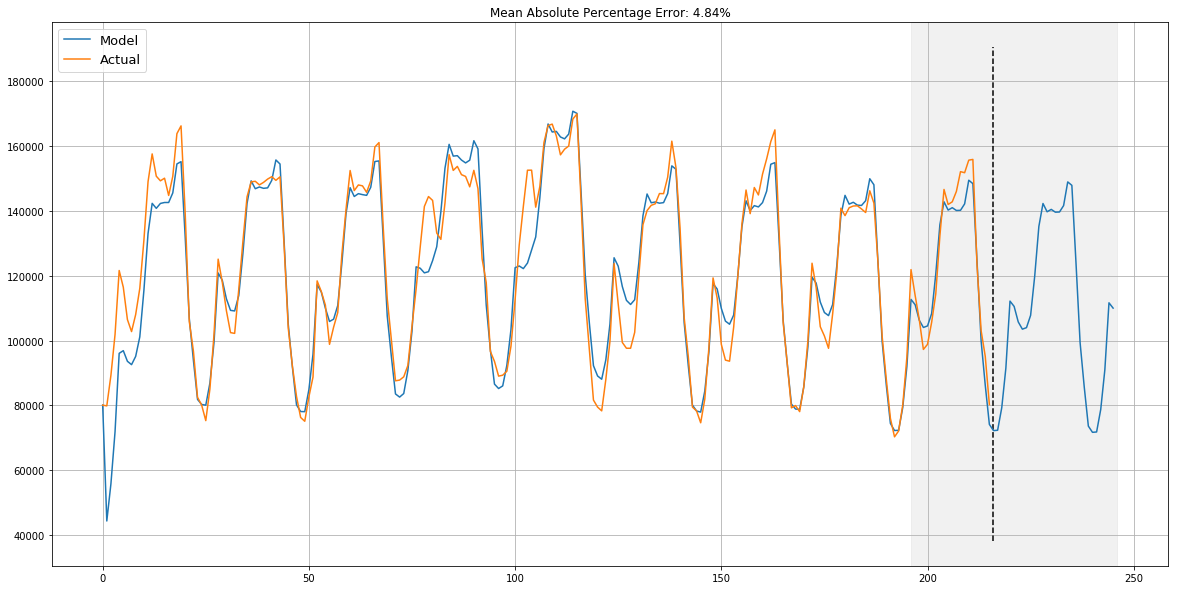

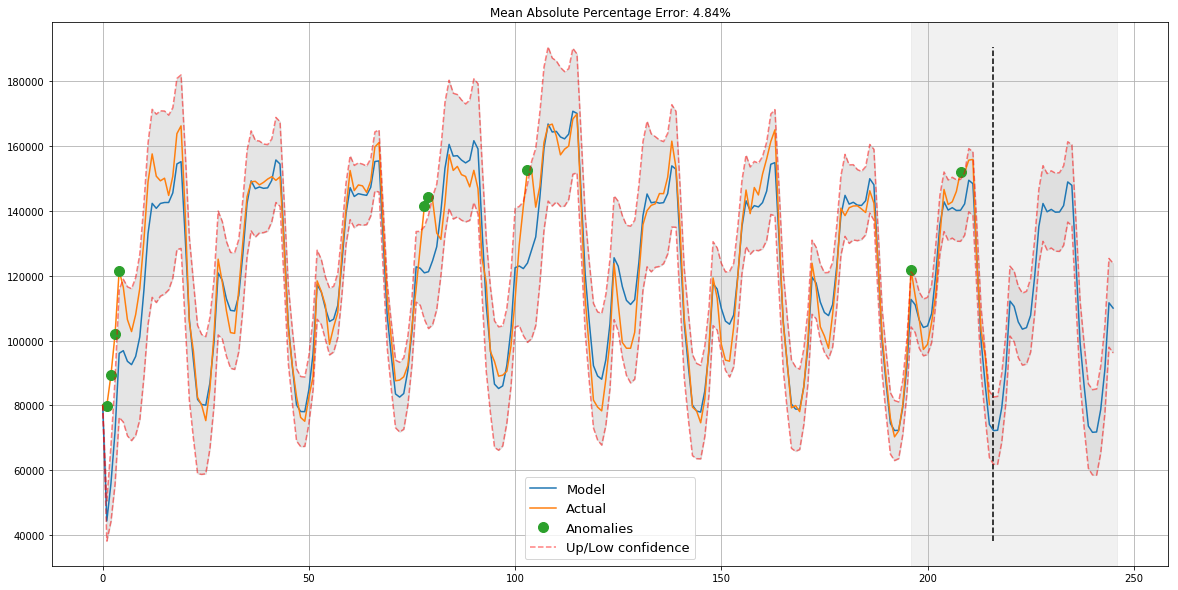

In [35]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(series_ad)
plotHoltWinters(series_ad, plot_intervals=True, plot_anomalies=True)


In [ ]:
## Judging by the chart, our model was able to successfully approximate the initial time series, catching daily
## seasonality, overall downwards trend and even some anomalies. If you take a look at the modeled deviation, you
## can clearly see that the model reacts quite sharply to the changes in the structure of the series but then
## quickly returns deviation to the normal values, “forgetting” the past. This feature of the model allows us to
## quickly build anomaly detection systems even for quite noisy series without spending too much time and money on
## preparing data and training the model.

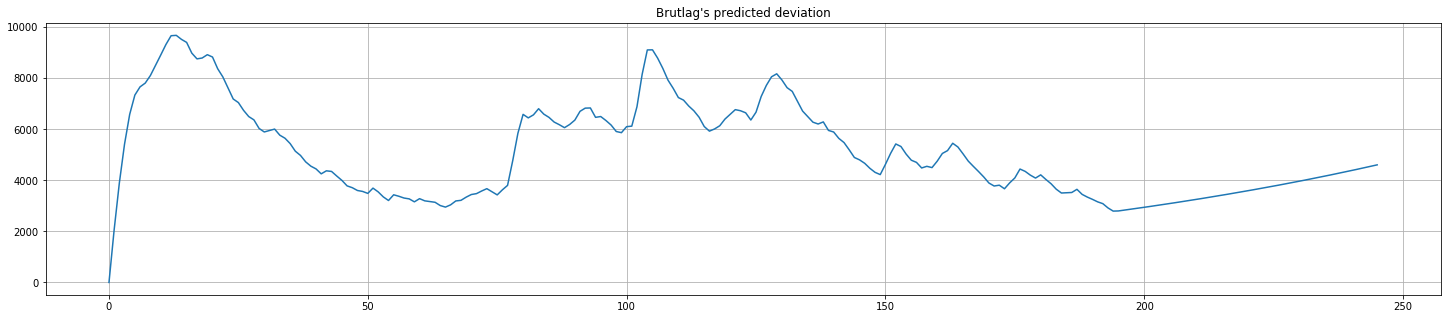

In [36]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");


In [ ]:
## Pl. notice above that deviation increases when we have anomalies

## Now, below, we’ll apply the same algorithm for the second series which, as we know, has trend and 30-day 
## seasonality

In [37]:
%%time
data = currency_series[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()


0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 2.75 s


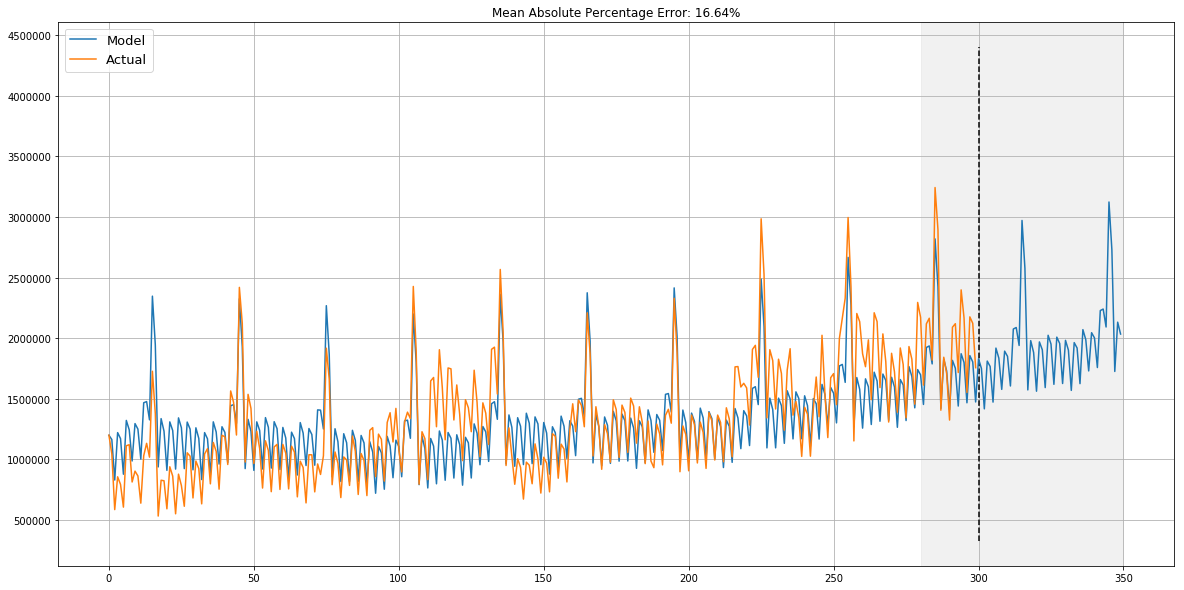

In [39]:
plotHoltWinters(currency_series)

## Looks quite adequate, model has caught both upwards trend and seasonal spikes and overall fits our values
## nicely

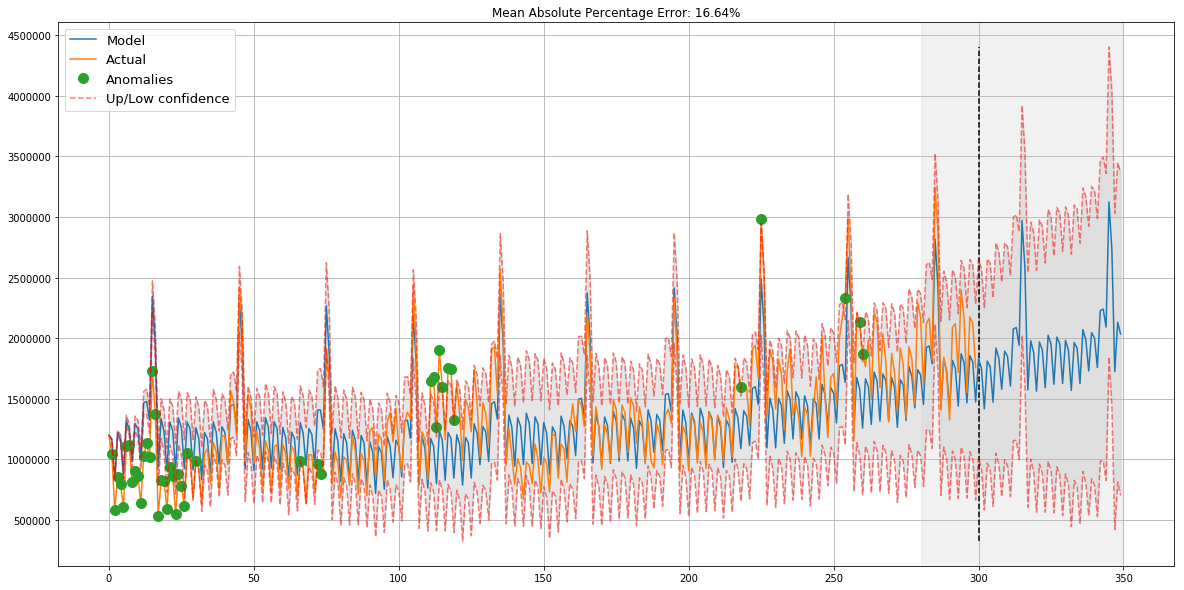

In [40]:
plotHoltWinters(currency_series, plot_intervals=True, plot_anomalies=True)

## Caught some anomalies as well

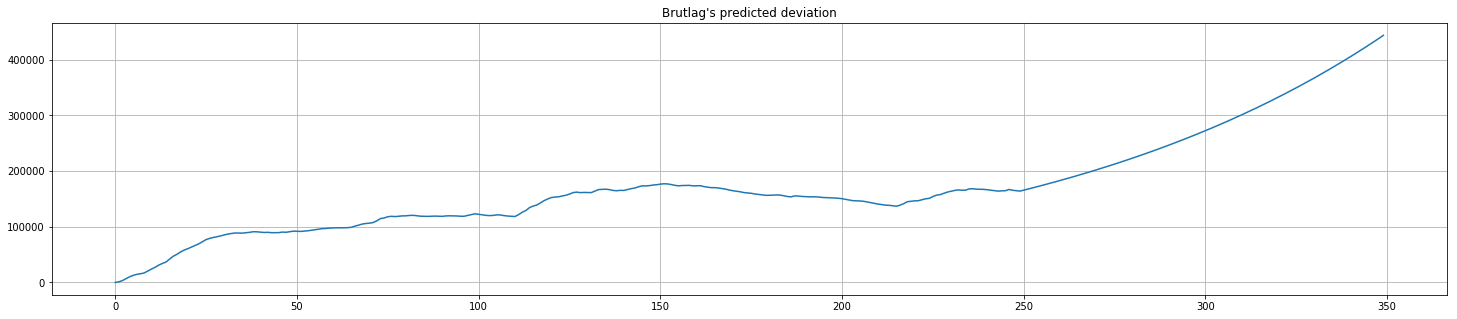

In [41]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## Deviations increases as forecast period moves further